# ELVTR Data Science Main Project

## Deliverables

### 01 Git Repository

Include all project code with a README file containing a high-level project description.

Example README guide: [Make a README](link-to-readme-guide)

### 02 Report

* Methodology, approach, and model selection rationale.
* Advantages and limitations of the chosen model.
* Architecture of the final solution.
* Considerations on deployment and scalability of the solution - i.e., how will the model be used in BAU by the business?
* Estimated impact/ROI of the project.

# Data Science in Finance: Lending Club Loan Analysis

## Project Overview

Lending Club has tasked us with preparing a loan application dataset for analysis and predictive modeling. 

The key tasks include data cleaning, exploratory data analysis, and building a predictive model for loan classification. An optional component involves building a real-time scoring application.

**Project Objectives**:
- Clean and preprocess the data.
- Perform exploratory data analysis (EDA) to gain insights.
- Develop a predictive model for loan application approval.
- (Optional) Build a real-time scoring application.

**Dataset Description**:
The dataset consists of loan application records, including various financial metrics and the application status. The data dictionary is provided for understanding the attributes.

**Dataset Path**:
- CSV: `data/1-raw/lending-club-2007-2020Q3/Loan_status_2007-2020Q3-100ksample.csv`
- Data Dictionary: `data/1-raw/lending-club-2007-2020Q3/LCDataDictionary.xlsx`

In [ ]:
pwd

## Importing Required Libraries


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Pandas display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Plot settings for consistent figure size (A4 landscape top half)
FIG_WIDTH = 11.69  # Width
FIG_HEIGHT = 4.14  # Height

# Set the theme for Seaborn plots
sns.set_theme(style='whitegrid')

## Load Data Set

In [ ]:
# Load the data xlsx file as a dataframe
df = pd.read_csv("c:\\Users\\kiera\\OneDrive\\Documents\\GitHub\\dsif-git-main-project\\elvtr_main_project\\data\\raw\\Loan_status_2007-2020Q3\\Loan_status_2007-2020Q3-100k-Full-Data.csv")

# Clean headers in the existing DataFrame 'df'
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# Display cleaned headers
print("Cleaned headers:", df.columns.tolist())

df.shape

In [ ]:
# Load the data dictionary CSV file as a dataframe
df_data_dict = pd.read_excel("c:\\Users\\kiera\\OneDrive\\Documents\\GitHub\\dsif-git-main-project\\elvtr_main_project\\data\\raw\\Loan_status_2007-2020Q3\\LCDataDictionary.xlsx")

# Clean headers in the existing DataFrame 'df'
df_data_dict.columns = df_data_dict.columns.str.strip().str.lower().str.replace(" ", "_")

# Display cleaned headers
print("Cleaned headers:", df_data_dict.columns.tolist())

df_data_dict.shape

In [ ]:
# Copies the columns and descriptions from the data dictionary into a data frame for future recall.
# Initialize empty lists for LoanStatNew and Description
loanstatnew = []
description = []

# Iterate through each row in the DataFrame and populate lists
for _, row in df_data_dict.iterrows():
    loanstatnew.append(row['loanstatnew'])
    description.append(row['description'])

# Apply left-aligned styling to both headers and data cells
styled_df_data_dict = df_data_dict.style.set_properties(
    **{'text-align': 'left', 'white-space': 'nowrap'}
).set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'left')]}]
)

# Display styled DataFrame
styled_df_data_dict


In [ ]:
#load the employtment mapping CSV file as a dataframe
df_emp_title = pd.read_csv("c:\\Users\\kiera\\OneDrive\\Documents\\GitHub\\dsif-git-main-project\\elvtr_main_project\\data\\raw\\emp_title_mapping.csv")

# Clean headers in the existing DataFrame
df_emp_title.columns = df_emp_title.columns.str.strip().str.lower().str.replace(" ", "_")

# Display cleaned headers
print("Cleaned headers:", df_emp_title.columns.tolist())

df_emp_title.shape

After analysing our data dictionary it is possible to class our columns into figurative categories to better organise our analysis. 

These categories are, for now:

- Credit history, 
- Current Debt and Payment behaviours, 
- Employement, 
- Credit inquiries

In [ ]:
# Initialize empty lists for LoanStatNew and Description
jobtitle = []
job_category = []

# Iterate through each row in the DataFrame and populate lists
for _, row in df_emp_title.iterrows():
    jobtitle.append(row['job_title'])
    job_category.append(row['category'])

# Apply left-aligned styling to both headers and data cells
styled_df_emp_title = df_emp_title.style.set_properties(
    **{'text-align': 'left', 'white-space': 'nowrap'}
).set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'left')]}]
)

# Display styled DataFrame
styled_df_emp_title

In [ ]:
# Cross table on 'category' in df_emp_title
category_crosstab = pd.crosstab(index=df_emp_title['category'], columns='count').sort_values(by='count', ascending=False)

# Display the crosstab
category_crosstab

## Display Basic Data Discovery

In [ ]:
df.info()

Our data contains 143 columns and 99999 rows of data. It is comprised of numerical (float, int) and categorical data (object)

In [ ]:
df.head()

Let's remove the first two columns but keep id for future reference. We've renamed our df to df_dropped in the process.

In [ ]:
# Remove specified columns from df
#df = df.drop(df.columns[[0, 1]], axis=1) # remove by index number, good for quick changes but hard to keep track of edits. Keeping for records.
df_dropped = df.drop(columns=['unnamed:_0.1', 'unnamed:_0'])


# Display the updated DataFrame
df_dropped.head()[df_dropped.columns[:3]]

The first two columns have been removed succesfully.

In [ ]:
df_dropped.describe()

Let's start by converting our data into lists for further processing.

In [13]:
def split_data_frame(features_list, df):
    """
    Splits the provided DataFrame into three lists containing Boolean, Numerical, and Categorical column names.
    Converts floats with trailing zeros into integers where appropriate and replaces NaN values 
    with 0 for integers and 0.00 for floats.

    Parameters:
    features_list (list): List of column names to be checked.
    df (pd.DataFrame): The input DataFrame to split.

    Returns:
    tuple: A tuple containing three lists (boolean_cols, numerical_cols, categorical_cols).
    """
    boolean_cols, numerical_cols, categorical_cols = [], [], []

    # Define acceptable boolean values
    acceptable_boolean_values = {0, 1, True, False, 0.0, 1.0}

    # Helper function to classify column types
    def classify_column(col):
        if col not in df.columns:
            print(f"Warning: Column '{col}' not found in DataFrame.")
            return

        column_series = df[col]

        # Classify Boolean columns
        if pd.api.types.is_bool_dtype(column_series) or all(column_series.dropna().isin(acceptable_boolean_values)):
            boolean_cols.append(col)
        
        # Classify Numerical columns
        elif pd.api.types.is_numeric_dtype(column_series):
            if column_series.dtype == 'float64' and all(column_series.dropna() == column_series.dropna().astype(int)):
                df[col] = column_series.fillna(0).astype(int)
            else:
                df[col] = column_series.fillna(0 if column_series.dtype == 'int64' else 0.00)
            numerical_cols.append(col)
        
        # Classify Categorical columns
        else:
            categorical_cols.append(col)

    # Iterate over each feature to classify
    for col in features_list:
        classify_column(col)

    # Print a summary of column counts
    print(f"Summary of column counts:")
    print(f"Boolean columns: {len(boolean_cols)}")
    print(f"Numerical columns: {len(numerical_cols)}")
    print(f"Categorical columns: {len(categorical_cols)}")
    print(f"Total features processed: {len(features_list)}")

    return boolean_cols, numerical_cols, categorical_cols

# Example usage:
# boolean_list, numerical_list, categorical_list = split_data_frame(new_features, df)


##### Numerical Processing

In [14]:
def analyze_numeric_columns(numeric_cols, dataframe):
    """
    Analyze and visualize numeric columns in a DataFrame.

    Parameters:
    numeric_cols (list): List of numeric column names to analyze.
    dataframe (pd.DataFrame): The DataFrame containing the data.
    """
    for column in numeric_cols:
        print(f"\nSummary Statistics and Analysis for Numeric Column: {column}")

        # Check if the column exists in the DataFrame
        if column not in dataframe.columns:
            print(f"Column '{column}' is not found in the DataFrame. Skipping...")
            continue

        # Ensure the column is converted to numeric
        dataframe.loc[:, column] = pd.to_numeric(dataframe[column], errors='coerce')

        # Drop NaN values to ensure we have numeric data for analysis
        numeric_data = dataframe[column].dropna()

        if numeric_data.empty:
            print(f"No valid numeric data available for column: {column}. Skipping...")
            continue  # Skip the column if there's no valid data

        # Calculate z-scores
        z_scores = (numeric_data - numeric_data.mean()) / numeric_data.std()

        # Calculate IQR
        Q1 = numeric_data.quantile(0.25)
        Q3 = numeric_data.quantile(0.75)
        IQR = Q3 - Q1

        # Identify outliers based on z-scores (z > 3 or z < -3)
        outliers_z = numeric_data[(z_scores > 3) | (z_scores < -3)]

        # Identify outliers based on IQR
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers_iqr = numeric_data[(numeric_data < lower_bound) | (numeric_data > upper_bound)]

        # Create a figure for the distribution and box plot
        fig, axs = plt.subplots(1, 2, figsize=(FIG_WIDTH, FIG_HEIGHT))

        # Distribution plot (histogram)
        sns.histplot(numeric_data, kde=True, bins=10, ax=axs[0])
        axs[0].set_title(f'Distribution of {column}')
        axs[0].set_xlabel(column)
        axs[0].set_ylabel('Frequency')

        # Box plot for outlier detection
        sns.boxplot(x=numeric_data, ax=axs[1])
        axs[1].set_title(f'Box Plot for {column} (Outlier Detection)')
        axs[1].set_xlabel(column)

        # Adjust layout to prevent overlap
        plt.tight_layout()
        plt.show()

        # Summary Statistics
        print(f"\nSummary Statistics for Numeric Column '{column}':")
        print(numeric_data.describe())

        # Interquartile Range (IQR)
        print(f"\nInterquartile Range (IQR): {IQR:.4f}")
        print(f"Lower Bound for Outliers (IQR method): {lower_bound:.4f}")
        print(f"Upper Bound for Outliers (IQR method): {upper_bound:.4f}")
        print(f"Number of Outliers (IQR method): {len(outliers_iqr)}")

        # Display outliers based on IQR
        #if not outliers_iqr.empty:
        #    print("\nOutliers detected using the IQR method:")
        #    print(outliers_iqr)
        #else:
        #    print("\nNo outliers detected using the IQR method.")

        # Z-scores
        print("\nZ-score Summary:")
        print(z_scores.describe())

        print(f"\nNumber of Outliers (Z-score method): {len(outliers_z)}")

        # Display outliers based on Z-scores
        #if not outliers_z.empty:
        #    print("\nOutliers detected using the Z-score method:")
        #    print(outliers_z)
        #else:
        #    print("\nNo outliers detected using the Z-score method.")

        # Skewness
        skewness_value = skew(numeric_data)
        print(f"\nSkewness: {skewness_value:.4f}")

        # Normality Tests
        print("\nNormality Tests:")
        # D'Agostino's K^2 Test
        k2_stat, k2_p = normaltest(numeric_data)
        print(f"D'Agostino's K^2 Test: Statistic={k2_stat:.4f}, p-value={k2_p:.4f}")

        # Shapiro-Wilk Test
        shapiro_stat, shapiro_p = shapiro(numeric_data)
        print(f"Shapiro-Wilk Test: Statistic={shapiro_stat:.4f}, p-value={shapiro_p:.4f}")

        # Anderson-Darling Test
        anderson_result = anderson(numeric_data)
        print(f"Anderson-Darling Test: Statistic={anderson_result.statistic:.4f}")
        for i in range(len(anderson_result.critical_values)):
            sl, cv = anderson_result.significance_level[i], anderson_result.critical_values[i]
            if anderson_result.statistic < cv:
                result = "Accept"
            else:
                result = "Reject"
            print(f"At {sl}% significance level, critical value: {cv:.4f}, {result} the null hypothesis of normality")

        # Kolmogorov-Smirnov Test against normal distribution
        # ks_stat, ks_p = kstest(numeric_data, 'norm', args=(numeric_data.mean(), numeric_data.std()))
        # print(f"Kolmogorov-Smirnov Test: Statistic={ks_stat:.4f}, p-value={ks_p:.4f}")


##### Boolean Processing

In [15]:
def analyze_boolean_columns(boolean_cols, dataframe):
    """
    Analyze and visualize boolean columns in a DataFrame.

    Parameters:
    boolean_cols (list): List of boolean column names to analyze.
    dataframe (pd.DataFrame): The DataFrame containing the data.
    """
    for column in boolean_cols:
        print(f"\nSummary Statistics and Analysis for Boolean Column: {column}")

        # Check if the column exists in the DataFrame
        if column not in dataframe.columns:
            print(f"Column '{column}' is not found in the DataFrame. Skipping...")
            continue

        # Cast the column to boolean in case it contains 1/0 or other non-boolean values
        dataframe[column] = dataframe[column].astype(bool)

        # Prepare boolean counts
        boolean_counts = dataframe[column].value_counts()

        # Create a figure with two subplots
        fig, axs = plt.subplots(1, 2, figsize=(FIG_WIDTH, FIG_HEIGHT)) # Configured at the beginning of the file for image consistancy

        # Bar plot using 'x' parameter
        sns.countplot(
            x=column,
            data=dataframe,
            ax=axs[0]
        )
        axs[0].set_title(f'Boolean Distribution for {column}')
        axs[0].set_xlabel(column)
        axs[0].set_ylabel('Count')

        # Pie chart on the right subplot
        boolean_counts.plot.pie(
            autopct='%1.1f%%',
            ax=axs[1],
            startangle=90
        )
        axs[1].set_title(f'Proportion of True/False for {column}')
        axs[1].set_ylabel('')

        # Adjust layout to prevent overlap
        plt.tight_layout()
        plt.show()

        # Display summary statistics for boolean data
        print(f"\nSummary for Boolean Column '{column}':")
        true_count = boolean_counts.get(True, 0)
        false_count = boolean_counts.get(False, 0)
        total_count = true_count + false_count
        true_percentage = (true_count / total_count) * 100 if total_count > 0 else 0

        print(f"Count of True: {true_count}")
        print(f"Count of False: {false_count}")
        print(f"Percentage of True: {true_percentage:.2f}%")


##### Categorical Processing

In [16]:
def analyze_categorical_columns(categorical_cols, dataframe):
    """
    Analyze and visualize categorical columns in a DataFrame.

    Parameters:
    categorical_cols (list): List of categorical column names to analyze.
    dataframe (pd.DataFrame): The DataFrame containing the data.
    """
    for column in categorical_cols:
        print(f"\nSummary Statistics and Analysis for Categorical Column: {column}")

        # Check if the column exists in the DataFrame
        if column not in dataframe.columns:
            print(f"Column '{column}' is not found in the DataFrame. Skipping...")
            continue

        # Prepare category counts and percentages
        category_counts = dataframe[column].value_counts()
        category_percentages = dataframe[column].value_counts(normalize=True) * 100

        # Display bar plot and pie chart
        fig, axs = plt.subplots(1, 2, figsize=(FIG_WIDTH, FIG_HEIGHT))

        # Bar plot using 'x' parameter
        sns.countplot(
            x=column,
            data=dataframe,
            ax=axs[0]
        )
        axs[0].set_title(f'Frequency Distribution for {column} (Categorical Data)')
        axs[0].set_xlabel(column)
        axs[0].set_ylabel('Frequency')
        plt.xticks(rotation=45, ha='right')

        # Pie chart on the right subplot
        category_counts.plot.pie(
            autopct='%1.1f%%',
            ax=axs[1],
            title=f'Proportion of Categories for {column}',
            startangle=90
        )
        axs[1].set_ylabel('')

        # Adjust layout to prevent overlap
        plt.tight_layout()
        plt.show()

        print(f"\nFrequency Table for '{column}':")
        freq_table = pd.DataFrame({'Count': category_counts, 'Percentage': category_percentages})
        print(freq_table)


In [ ]:
# Create lists of data for further analysis
boolean_list, numerical_list, categorical_list = split_data_frame(df_dropped, df_dropped) # first input variable is the features we're interested in the second the data frame that contains the values.

### 01 Data Preparation and Cleaning

Perform thorough data cleaning on the provided dataset, including but not limited to the following steps:

* Handling missing values (imputation or removal)
* Converting data types to appropriate formats
* Removing duplicate records
* Detecting and handling outliers
* Standardizing and normalizing data
* Encoding categorical variables
* Cleaning and preprocessing string data
* Extracting features from date columns

In [ ]:
# Cross table of data types in df
dtype_crosstab = df.dtypes.value_counts().reset_index()
dtype_crosstab.columns = ['Data Type', 'Count']

# Display the cross table
dtype_crosstab

This calls the split_data_frame function above create three lists to capture the sorting outputs in. 

These will later be used to pull some graphs to evaluate the data and what possible transformations we've missed.


#### Handling missing values (imputation or removal)

Let's import missingno

In [19]:
import missingno as msno

Let's check for missing data using missingno

In [ ]:
# Check for missing values in each column
missing_values = df_dropped.isnull().sum().sort_values(ascending=False)
print(f"There is a total of: {len(missing_values)} columns that are missing data\n")

missing_values[missing_values > 0] # Display only columns with missing values > X

Looking at our results we can make the assumption that several columns are derivatives or linked in some shape or form to others due to the exact count of missing data.

In [ ]:
# Filter for columns with missing values greater than 0
missing_values_graph = df_dropped[missing_values[missing_values > 0].index]

print("Data Missing Values\n")

# Visualize the missing data using the missingno library
msno.heatmap(missing_values_graph)
# msno.dendrogram(missing_values_graph) #removed for the final anlysis to avoid cluttering the document with the same data but a different way to show it

In [ ]:
df_dropped['hardship_status'].value_counts()

Let's align the wording.

In [23]:
# Correct references to 'completed' to 'complete' in the 'hardship_status' column
df_dropped['hardship_status'] = df_dropped['hardship_status'].replace('COMPLETED', 'COMPLETE')

In [ ]:
df_dropped['hardship_status'].value_counts()

In [ ]:
df_dropped['application_type'].value_counts()

In [ ]:
# Create the 'hardship_existing' column, setting it to 1 if 'hardship_status' is 'active' or 'broken', otherwise 0
df_dropped['joint_applicant'] = df_dropped['dti_joint'].apply(lambda x: 1 if x in ['Joint App'] else 0)

# Display the first few rows to verify the changes
print(df_dropped[['joint_applicant', 'dti_joint']].head())

Let's plot our missing data and search for possible correlations.

##### Missing Data Strategy
Instead of dropping columns with a high number of missing values, we may want to retain them for our analysis. 

Following the logic of Abraham Wald's famous airplane and bullet hole logic, it is beneficial to analyse the data we don't have rather than discard potentially useful data i.e. the absence of one is a indicator in its own right.

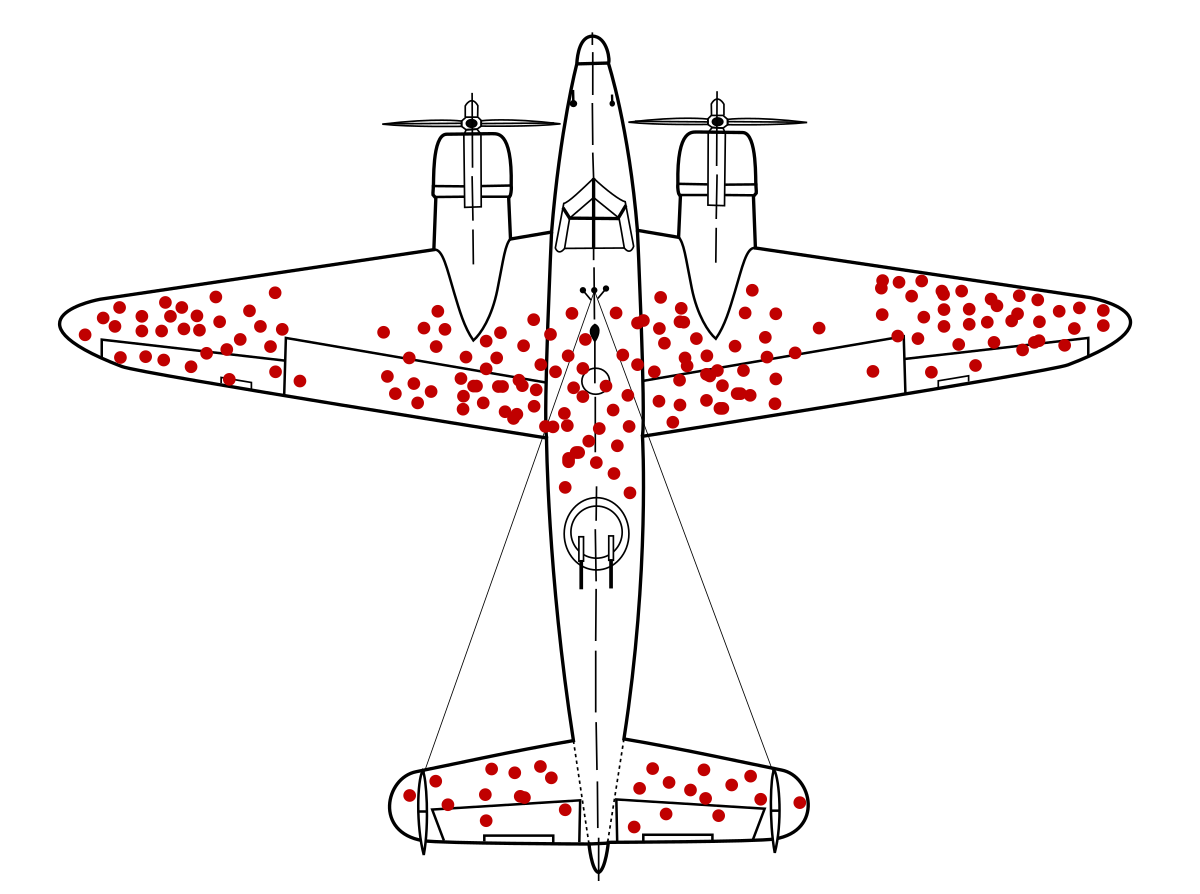

##### Creating Missing Value Indicators

To reiterate instead of dropping columns or rows with missing data, we create missing value indicators for the columns with missing entries that we feel would be good indicators/features for loan application approvals.

This means that for each column with missing values, a new binary indicator column is created, where `1` represents a missing value and `0` indicates that a value was present. 

This approach ensures that we retain as much information as possible from the original dataset while also capturing the fact that missing values themselves may provide valuable insight. For instance, missing income information could be an indicator of a higher default risk and by proxy maybe something that should reduce the score attributed to a client.

#### Converting data types to appropriate formats

Let's start by calling our split_list_function which will create three seperate lists from our data frame which we can then use for our analysis.

In [ ]:
# Create lists of data for further analysis
boolean_list, numerical_list, categorical_list = split_data_frame(df_dropped, df_dropped) # first input variable is the features we're interested in the second the data frame that contains the values.

Here we can see that our data contains 3 boolean values. 2 of which we created earlier as markers for active hardship and joint applications.

Let's explore our categorical values in search of dtypes that we can convert to numercial (int, float) values.

In [ ]:
import re

# List to store features that contain any numerical values (even within mixed text)
categorical_list_with_numerical_values = []

# Iterate through each column in categorical_list
for column in categorical_list:
    # Check if the column contains any values with numerical characters
    if df_dropped[column].apply(lambda x: bool(re.search(r'\d', str(x)))).any():
        categorical_list_with_numerical_values.append(column)
        print(f"Column '{column}' contains numerical values.")

This tells us there are potential columns with numercial values that we should evaluate further and potentially convert to int or float values.

In [ ]:
df_dropped[categorical_list_with_numerical_values].columns()

In [ ]:
# Creaet a list of values to encode from string to int or float
df_dropped[categorical_list_with_numerical_values].head()

Before running our graphical analysis let's start by filtering out categorical values with over 20 unique values.

In [ ]:
# Define the threshold for unique values
threshold = 20

# Create a list to store columns that meet the threshold criteria
categorical_list_updated = [column for column in categorical_list if df_dropped[column].nunique() < threshold]

# Print out the columns and their unique values if needed
for column in categorical_list_updated:
    unique_values = df_dropped[column].nunique()
    print(f"Column '{column}' has {unique_values} unique values (below threshold).")

In [ ]:
analyze_categorical_columns(categorical_list_with_numerical_values, df_dropped) # columns features and data frame

In [ ]:
analyze_categorical_columns(categorical_list_updated, df_dropped)

##### Convert to float & int

- **emp_length**: Convert to a float (create a new feature `emp_length_clean_kn`)
- **int_rate**: Convert to a float (create a new feature `int_rate_int_clean_kn`)
- **revol_util**: Convert to a float (create a new feature `revol_util_int_clean_kn`)

Before making these changes let's create a copy of our df.

#### Removing Features

In [ ]:
# Remove specified columns from df
#df = df.drop(df.columns[[0, 1]], axis=1) # remove by index number, good for quick changes but hard to keep track of edits. Keeping for records.
df_dropped = df_dropped.drop(columns=['url', 'zip_code', 'pymnt_plan', 'hardship_type']) # identified in the categorical data analysis
 
# Display the updated DataFrame
df_dropped.head()

#### String to numerical

In [ ]:
import re

# Define the columns that need to be converted from string to integer
string_columns_to_convert = ['term', 'emp_length']  # features to replace with int values

# Convert each specified column to an integer in a new column
for column in string_columns_to_convert:
    # Extract numerical part and convert to integer
    df_dropped[f"{column}_int_kn"] = df_dropped[column].apply(lambda x: int(re.search(r'\d+', str(x)).group()) if pd.notnull(x) else None)

# Drop the original string columns
df_dropped.drop(columns=string_columns_to_convert, inplace=True)

# Verify the results
df_dropped.head()

#### Creating logical groups 

In [ ]:
# Define the logical groupings for 'loan_status'
loan_status_groupings = {
    'Fully Paid': 'Completed',
    'Current': 'In Progress',
    'Charged Off': 'Defaulted',
    'Late (31-120 days)': 'Late',
    'In Grace Period': 'Late',
    'Late (16-30 days)': 'Late',
    'Does not meet the credit policy. Status:Fully Paid': 'Completed',
    'Issued': 'In Progress',
    'Does not meet the credit policy. Status:Charged Off': 'Defaulted',
    'Default': 'Defaulted'
}

# Apply the grouping to the 'loan_status' column
df_dropped['loan_status_grouped_kn'] = df_dropped['loan_status'].replace(loan_status_groupings)

# Verify the groupings
print(df_dropped['loan_status_grouped_kn'].value_counts())


In [ ]:
# Define the logical groupings for 'hardship_reason'
hardship_reason_groupings = {
    'INCOMECURT': 'Job-Related Income Loss',
    'UNEMPLOYED': 'Job-Related Income Loss',
    'UNEMPLOYMENT': 'Job-Related Income Loss',
    'INCOME_CURTAILMENT': 'Job-Related Income Loss',
    'REDCDHOURS': 'Job-Related Income Loss',
    'REDUCED_HOURS': 'Job-Related Income Loss',
    'FURLOUGH': 'Job-Related Income Loss',
    'MEDICAL': 'Health and Medical Issues',
    'DISABILITY': 'Health and Medical Issues',
    'NATURAL_DISASTER': 'Natural or External Events',
    'NATDISAST': 'Natural or External Events',
    'FINANCIAL': 'Financial Strain',
    'EXCESSIVE_OBLIGATIONS': 'Financial Strain',
    'EXCESSOBLI': 'Financial Strain',
    'DIVORCE': 'Family Circumstances',
    'FAMILY_DEATH': 'Family Circumstances',
    'DEATH': 'Family Circumstances'
}

# Apply the grouping to the 'hardship_reason' column
df_dropped['hardship_reason_grouped_kn'] = df_dropped['hardship_reason'].replace(hardship_reason_groupings)

# Verify the groupings
print(df_dropped['hardship_reason_grouped_kn'].value_counts())


In [ ]:
# Define the logical groupings for 'hardship_loan_status'
hardship_loan_status_groupings = {
    'ACTIVE': 'Active or Current',
    'GRACE_CURRENT': 'Active or Current',
    'Current': 'Active or Current',
    'CURRENT': 'Active or Current',
    'Late (16-30 days)': 'Late',
    'Late (31-120 days)': 'Late',
    'In Grace Period': 'Grace Period',
    'INCOLLECTION': 'In Collection or Delinquent',
    'DELINQUENT': 'In Collection or Delinquent'
}

# Apply the grouping to the 'hardship_loan_status' column
df_dropped['hardship_loan_status_grouped_kn'] = df_dropped['hardship_loan_status'].replace(hardship_loan_status_groupings)

# Verify the groupings
print(df_dropped['hardship_loan_status_grouped_kn'].value_counts())


##### Emp_length conversion

In [ ]:
# Extract numerical values from 'emp_length' and convert it to an integer
df_dropped['emp_length'] = df_dropped['emp_length'].str.extract(r'(\d+)').astype(float).fillna(0).astype(int)

#### Removing duplicate records

#### Detecting and handling outliers

Let's run our numerical data analysis.

#### Standardising and normalising data

#### Encoding categorical variables

Let's inspect our categorical data for encoding opportunities. Let's check for categorical data with numerical values these are candidates for int and float transformations.

#### Cleaning and preprocessing string data

Let's check for multicollinenearity

In [ ]:
# Calculate the correlation matrix for numerical columns
corr_matrix = df_dropped[numerical_list].corr().abs()

# Set the threshold for high correlation
threshold = 0.90

# Find pairs of features with correlation greater than the threshold
high_corr_pairs = np.where(corr_matrix > threshold)
high_corr_pairs = [(corr_matrix.index[x], corr_matrix.columns[y])
                   for x, y in zip(*high_corr_pairs) if x != y and x < y]

# Display the pairs with high correlation
for pair in high_corr_pairs:
    print(f"Correlation between {pair[0]} and {pair[1]}: {corr_matrix.loc[pair[0], pair[1]]:.2f}")

#### Extracting features from date columns using RFE

#### Preliminary Data Feature selection

## 02 Exploratory Data Analysis

Conduct an in-depth analysis of the dataset with a focus on the target variable. The analysis should include:

* Exploring the distribution, symmetry, and potential issues with the target variable.
* Using visualization techniques (e.g., histograms, box plots, scatter plots) and statistical analysis to explore relationships between the target variable and independent variables.
* Identifying important variables with predictive relevance.
* Determining which variables or levels can be excluded.
* Identifying variables with outliers and applying transformations if necessary.
* Handling missing values and explaining the chosen treatment.
* Examining interrelationships between independent variables and considering transformations.
* Assessing class balance and addressing any imbalance if needed.
* Summarizing insights and plans to leverage the information.

Our Target variable is `loan_approval_score`

In [ ]:
df_dropped['loan_approval_score'] = []

#### Exploring the Distribution, Symmetry, and Potential Issues with the Target Variable

#### Using Visualization Techniques to Explore Relationships Between the Target Variable and Independent Variables

#### Identifying Important Variables with Predictive Relevance (RFE)

#### Determining Which Variables or Levels Can Be Excluded

#### Identifying Variables with Outliers and Applying Transformations if Necessary

#### Handling Missing Values and Explaining the Chosen Treatment

#### Examining Interrelationships Between Independent Variables and Considering Transformations

#### Assessing Class Balance and Addressing Any Imbalance if Needed

#### Summarizing Insights and Plans to Leverage the Information

### 03 Modelling

Recommend and justify a model to predict class membership of loan applications. The modeling phase should include:

* Selecting a baseline model for comparison.
* Recommending a challenger model with a detailed justification.
* Describing all data preprocessing steps and measurement of accuracy.
* Choosing appropriate models and evaluation metrics.
* Explaining the choice of models, preprocessing methods, and accuracy metrics.

### 04 Optional - Real-time scoring application

Build a "real-time" application that can score new loan application observations. The implementation details are at the consultant's discretion.